In [1]:
########## Part 1: Producing forecasts via traditional time series analysis (ARIMA)

In [2]:
%reset -f

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=10,6

In [3]:
# import CPI data (monthly data from 1961 to 2017)
cpi = pd.read_csv('../data/consumer_price_index/cpi.csv')

# create month index
cpi['month'] = pd.to_datetime(cpi['month'], infer_datetime_format=True)
cpi = cpi.set_index(['month'])

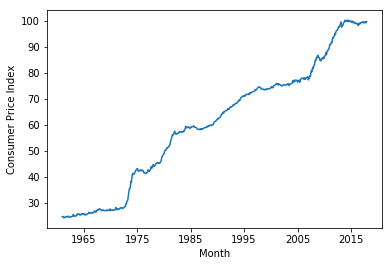

In [4]:
# plot graph
plt.xlabel('Month')
plt.ylabel('Consumer Price Index')
plt.plot(cpi['cpi']) # upward trend, hence not stationary

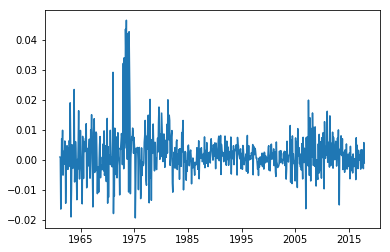

In [5]:
# remove trend: take first difference of log values
log_cpi = np.log(cpi)
dlog_cpi = log_cpi - log_cpi.shift(1)
plt.plot(dlog_cpi)
plt.show() # trend has been removed

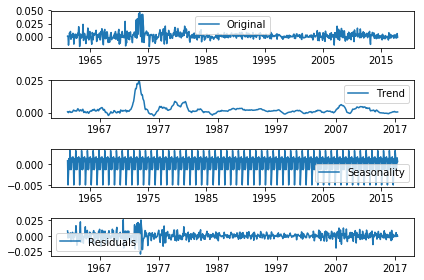

In [6]:
### remove seasonal component (if any)

# break down a time series into its trend, seasonal, and residual components
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(dlog_cpi.dropna())

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(dlog_cpi, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality') # seems that there is indeed seasonality
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# remove seasonal component
dlog_cpi_sa = dlog_cpi - seasonal

In [7]:
# confirm stationarity via augmented dickey-fuller test (null hypothesis: series is non-stationary)
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(dlog_cpi_sa['cpi'].dropna(), autolag='AIC') # use akaike IC to determine no. of lags to include in ADF test

print('p-value from ADF test is:', adf_test[1]) # reject the null of non-stationarity

p-value from ADF test is: 1.967207037788998e-06


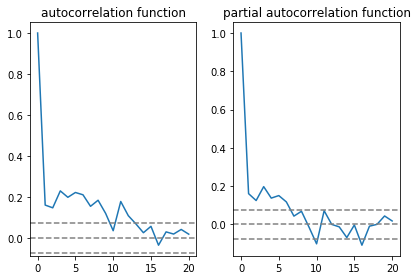

In [8]:
### determine number of autoregressive and moving average terms in AR and MA model respectively
from statsmodels.tsa.stattools import acf, pacf

dlog_cpi_sa.dropna(inplace=True)
lag_acf = acf(dlog_cpi_sa, nlags=20)
lag_pacf = pacf(dlog_cpi_sa, nlags=20, method='ols')

# plot ACF: to determine number of MA terms
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dlog_cpi_sa)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dlog_cpi_sa)), linestyle='--', color='gray')
plt.title('autocorrelation function')
# number of MA terms = 9 (acf graph enters confidence interval for the first time when # lags = 10)

# plot PACF: to determine number of AR terms
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(dlog_cpi_sa)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dlog_cpi_sa)), linestyle='--', color='gray')
plt.title('partial autocorrelation function')
plt.tight_layout()
# number of AR terms = 6 (pacf graph enters confidence interval for the first time when # lags = 7)

C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


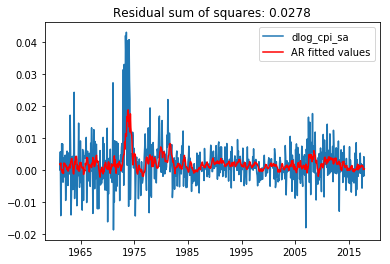

C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


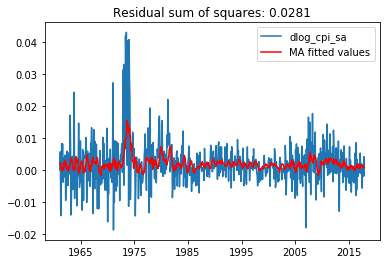

C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


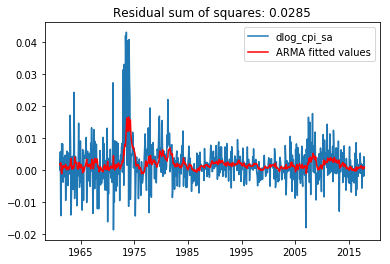

                              ARMA Model Results                              
Dep. Variable:                    cpi   No. Observations:                  683
Model:                     ARMA(6, 0)   Log Likelihood                2483.309
Method:                       css-mle   S.D. of innovations              0.006
Date:                Sun, 26 Aug 2018   AIC                          -4950.617
Time:                        10:08:30   BIC                          -4914.405
Sample:                    02-01-1961   HQIC                         -4936.603
                         - 12-01-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.154      0.002       0.001       0.003
ar.L1.cpi      0.0501      0.038      1.320      0.187      -0.024       0.125
ar.L2.cpi      0.0405      0.038      1.076      0.2

In [9]:
### let's compare AR vs MA vs ARMA
from statsmodels.tsa.arima_model import ARIMA

# AR
model = ARIMA(dlog_cpi_sa, order=(6, 0, 0))  
results_ar = model.fit(disp=-1)  
plt.plot(dlog_cpi_sa, label='dlog_cpi_sa')
plt.plot(results_ar.fittedvalues, color='red', label='AR fitted values')
plt.title('Residual sum of squares: %.4f'% sum((results_ar.fittedvalues-dlog_cpi_sa['cpi'])**2))
plt.legend(loc='best')
plt.show()

# MA
model = ARIMA(dlog_cpi_sa, order=(0, 0, 9))  
results_ma = model.fit(disp=-1)  
plt.plot(dlog_cpi_sa, label='dlog_cpi_sa')
plt.plot(results_ma.fittedvalues, color='red', label='MA fitted values')
plt.title('Residual sum of squares: %.4f'% sum((results_ma.fittedvalues-dlog_cpi_sa['cpi'])**2))
plt.legend(loc='best')
plt.show()

# ARMA
model = ARIMA(dlog_cpi_sa, order=(1, 0, 1))  
results_arma = model.fit(disp=-1)  
plt.plot(dlog_cpi_sa, label='dlog_cpi_sa')
plt.plot(results_arma.fittedvalues, color='red', label='ARMA fitted values')
plt.title('Residual sum of squares: %.4f'% sum((results_arma.fittedvalues-dlog_cpi_sa['cpi'])**2))
plt.legend(loc='best')
plt.show()

# AR model has the lowest RSS out of the three models

# view summary of best model
print(results_ar.summary())

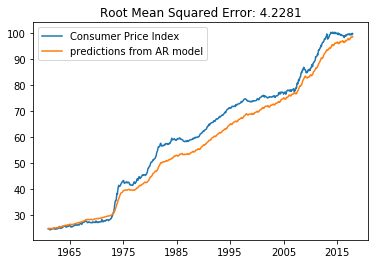

In [10]:
# generate in-sample predictions
predictions_ar = pd.Series(results_ar.fittedvalues, copy=True)

# transform predictions back to the original scale
predictions_ar = predictions_ar + seasonal['cpi'] # add seasonal component back to time series
predictions_ar = predictions_ar.cumsum() # reverse the first differencing performed earlier

x = pd.Series(log_cpi.iloc[0][0],index=log_cpi.index)
predictions_ar = x.add(predictions_ar,fill_value=0) # add back, to all rows, the log cpi from the first period

predictions_ar = np.exp(predictions_ar) # reverse the log transformation performed earlier

# compare transformed predictions against original series
plt.plot(cpi['cpi'], label='Consumer Price Index')
plt.plot(predictions_ar, label='predictions from AR model')
plt.title('Root Mean Squared Error: %.4f'% np.sqrt(sum((predictions_ar-cpi['cpi'])**2)/len(cpi['cpi'])))
plt.legend(loc='best')
plt.show() # predictions seem to co-move well with actual values, though actual values tend to exceed predictions

C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\A

C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\A

C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\A

C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\A

C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\USER\A

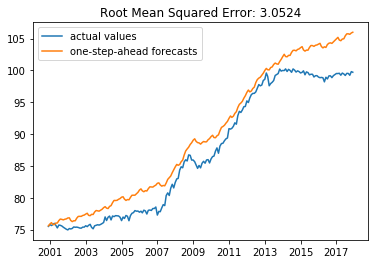

In [11]:
##### let's check the out-of-sample accuracy of the one-step-ahead forecasts

### split the data into train and test sets
train=dlog_cpi_sa[0:int(dlog_cpi_sa.shape[0]*0.7)]
test=dlog_cpi_sa[int(dlog_cpi_sa.shape[0]*0.7):dlog_cpi_sa.shape[0]]

### estimate the model via expanding window estimation, then generate out-of-sample one-step-ahead forecast. repeat for the length of the test set.
history=train['cpi']
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(6,0,0))
    model_fit = model.fit(disp=-1)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat[0])
    obs = test['cpi'][t:t+1]
    history = history.append(obs)

### transform predictions and test data back to the original scale
predictions = pd.DataFrame({'prediction':predictions})
predictions = predictions.set_index(test.index)

predictions['prediction'] = predictions['prediction'] + seasonal['cpi'][int(dlog_cpi_sa.shape[0]*0.7):dlog_cpi_sa.shape[0]]
predictions = predictions.cumsum()
predictions = predictions + log_cpi['cpi'][int(dlog_cpi_sa.shape[0]*0.7):int(dlog_cpi_sa.shape[0]*0.7)+1][0]
predictions = np.exp(predictions)

test = cpi[int(dlog_cpi_sa.shape[0]*0.7)+1:cpi.shape[0]]

### plot graph to show out-of-sample accuracy of 1-step ahead forecasts
plt.plot(test, label='actual values')
plt.plot(predictions, label='one-step-ahead forecasts')
plt.legend(loc='best')
plt.title('Root Mean Squared Error: %.4f'% np.sqrt(sum((predictions['prediction']-test['cpi'])**2)/len(test['cpi'])))
plt.show()

# out-of-sample predictions seem to co-move well with actual values, though forecasts tend to exceed actual values

In [12]:
########## Part 2: Producing forecasts via a machine learning model (LSTM network)

In [13]:
%reset -f

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
np.random.seed(123)

Using TensorFlow backend.


In [14]:
# import CPI data (monthly data from 1961 to 2017)
cpi = pd.read_csv('../data/consumer_price_index/cpi.csv')

# drop the 'month' column
month = cpi['month']
del cpi['month']

In [15]:
# normalize the dataset via min-max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
cpi_scaled = scaler.fit_transform(cpi)

In [16]:
# split the data into train and test data
sampleprop = 0.7 # adjust as desired
train_size = int(len(cpi_scaled) * sampleprop)
test_size = len(cpi_scaled) - train_size
train, test = cpi_scaled[0:train_size], cpi_scaled[train_size:len(cpi_scaled)]
print(len(train), len(test))

478 206


In [17]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=t and Y=t+look_back
look_back = 1 # adjust as desired
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [18]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [19]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))  # hidden layer contains 4 LSTM blocks
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=300, batch_size=1, verbose=0) # train the model

In [20]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore)) # LSTM model produces more accurate out-of-sample predictions than AR model

Train Score: 0.37 RMSE
Test Score: 0.56 RMSE


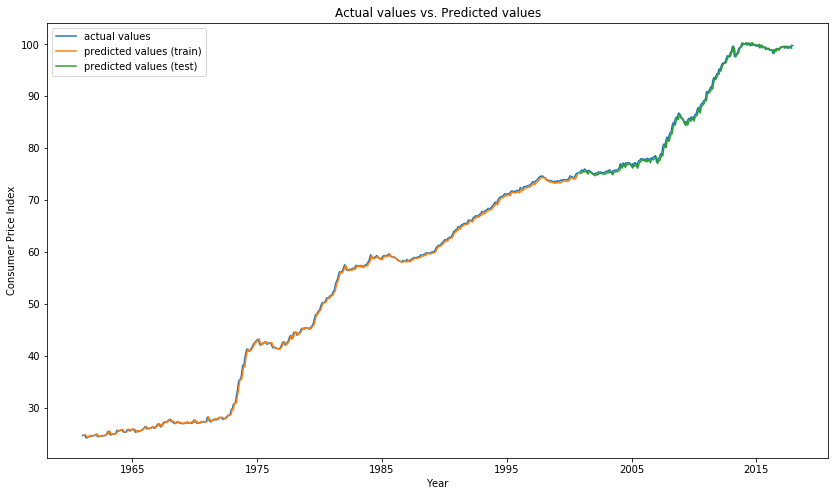

In [21]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(cpi)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(cpi)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(cpi)-1, :] = testPredict

# plot actual values and predictions
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=14,8

plt.plot(cpi, label='actual values')
plt.plot(trainPredictPlot, label='predicted values (train)')
plt.plot(testPredictPlot, label='predicted values (test)')
plt.legend(loc='best')
plt.title('Actual values vs. Predicted values')
plt.xlabel('Year')
plt.ylabel('Consumer Price Index')
plt.xticks(np.array([48,168,288,408,528,648]),['1965','1975','1985','1995','2005','2015'])
plt.show()

# the train and test accuracies are both near-perfect

In [22]:
import gc
gc.collect()

3810